In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def load_data(data_path):
    df = pd.read_csv(data_path, sep='\t', parse_dates=['ActivityTimeStamp'])
    df = df.sort_values(by=['Incident ID'])
    return df


In [3]:
data = load_data('./data/incidentProcess_custom.csv')

In [4]:
data.isnull().values.sum()

279328

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303819 entries, 0 to 303818
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Incident ID              303819 non-null  object        
 1   Activity                 303819 non-null  object        
 2   ActivityTimeStamp        303819 non-null  datetime64[ns]
 3   Asset Affected           303819 non-null  object        
 4   Asset Type Affected      303819 non-null  object        
 5   Asset SubType Affected   303819 non-null  object        
 6   Service Affected         303819 non-null  object        
 7   Status                   303819 non-null  object        
 8   Impact                   303819 non-null  int64         
 9   Urgency                  303819 non-null  int64         
 10  Priority                 303819 non-null  int64         
 11  Category                 303819 non-null  object        
 12  Number of Reassi

In [6]:
def incident_sorted_list(data, incident_id):
    '''
    '''
    df = pd.DataFrame()
    df = data[data['Incident ID'] == incident_id] # select all rows with incident_id
    # df['ActivityTimeStamp'] = pd.to_datetime(df['ActivityTimeStamp']) # parse as timestamp
    # df['ActivityTimeStamp'] = df['ActivityTimeStamp'].apply(
    #     lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) # transform
    df = df.sort_values(by=['ActivityTimeStamp'], ascending=True)
    # print(df)
    return df

In [7]:
def check_ping_pong(df):
    pingpong = 0
    assignments = []
    timedeltas = []
    for i in range(df.shape[0] - 1):
        activityA = df['Activity'].iloc[i]
        activityB = df['Activity'].iloc[i+1]
        if activityA == activityB:
            if df['Assignment Group'].iloc[i] != df['Assignment Group'].iloc[i+1]:
                assignments.append((df['Assignment Group'].iloc[i], df['Assignment Group'].iloc[i+1], activityA))
                timedeltas.append(df['ActivityTimeStamp'].iloc[i+1] - df['ActivityTimeStamp'].iloc[i])
                # hier dus eigenlijk een lijst met tuple (teamA en TeamB plus timestamps en misschien ook de activiteit in kwestie) returnen en na alle incidenten opslaan
                # print(df['Assignment Group'].iloc[i])
                # print(df['Assignment Group'].iloc[i+1])
                pingpong += 1
    return pingpong, assignments, timedeltas

In [8]:
def get_unique_incidents(df):
    return list(df['Incident ID'].unique())

In [9]:
get_unique_incidents(data)[100]

'IM0000147'

In [10]:
pd.options.mode.chained_assignment = None

In [11]:
pingpong_df = pd.DataFrame()
asset_types = []
pings_list = []
timedeltas = []
for (pos, i_id) in enumerate(get_unique_incidents(data)):
    # if pos == 1000:
    #     break
    sorted_incident = incident_sorted_list(data, i_id)
    pings, activities, timedelta = check_ping_pong(sorted_incident)
    timedeltas.append(timedelta)
    # print(sorted_incident['Asset Type Affected'].iloc[0], pings, activities)
    asset_types.append(sorted_incident['Asset Type Affected'].iloc[0])
    pings_list.append(pings)
    pingpong_df = pingpong_df.append({"Incident ID": i_id, "pings": pings}, ignore_index=True)

asset_type_pings_df = pd.DataFrame()
asset_type_pings_df['pings'] = pings_list
asset_type_pings_df['Asset Type'] = asset_types


In [12]:
pingpong_df['pings'].value_counts()

0     36826
1      5929
2      2001
3       864
4       393
5       250
6       131
7        59
8        56
9        36
10       20
11        9
12        7
14        5
16        4
13        4
19        2
21        1
18        1
26        1
15        1
17        1
Name: pings, dtype: int64

In [13]:
pingpong_df[pingpong_df['pings'] > 0].median()

pings    1.0
dtype: float64

Text(0, 0.5, 'Frequency')

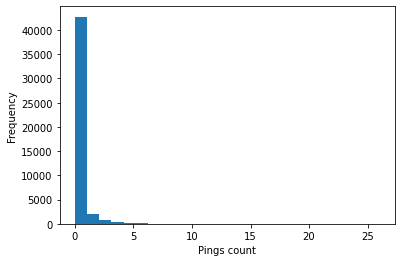

In [41]:
plt.hist(pingpong_df['pings'], bins=25)
plt.xlabel("Pings count")
plt.ylabel("Frequency")

In [15]:
timedeltas
flat_deltas = [x for xs in timedeltas for x in xs]


In [16]:
deltas_df = pd.DataFrame()
deltas_df['Time Deltas'] = flat_deltas

In [17]:
deltas_df.mean()

Time Deltas   1 days 04:32:45.369034406
dtype: timedelta64[ns]

In [37]:
deltas_df.median()

Time Deltas        0 days 01:14:45.500000
Time Deltas [s]                    4485.5
dtype: object

In [18]:
deltas_df.std()

Time Deltas   6 days 16:21:35.781311915
dtype: timedelta64[ns]

In [19]:
deltas_df.max()

Time Deltas   220 days 06:55:14
dtype: timedelta64[ns]

In [20]:
deltas_df.sum()

Time Deltas   21433 days 05:45:50
dtype: timedelta64[ns]

In [38]:
deltas_df['Time Deltas [s]'] = deltas_df['Time Deltas'].astype('timedelta64[s]')
result  = deltas_df[deltas_df['Time Deltas'].astype('timedelta64[s]') > 60 * 60 *24 * 7] 


In [39]:
result.shape

(511, 2)

Text(0.5, 1.0, 'Time deltas between pings')

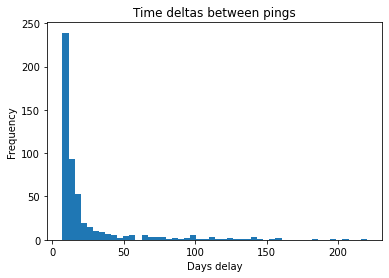

In [40]:
# deltas_df['Time Deltas'].dt.days.plot.hist(bins=20)
plt.hist((result['Time Deltas'].astype('timedelta64[h]') / 24), bins=50)
plt.xlabel("Days delay")
plt.ylabel("Frequency")
plt.title("Time deltas between pings")

Text(0, 0.5, 'Incident count')

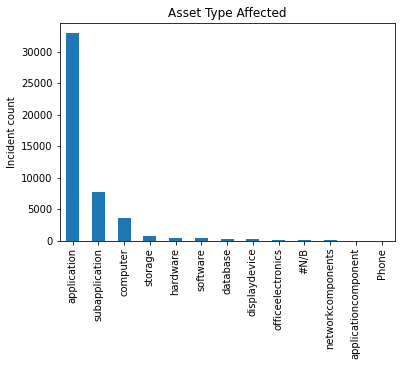

In [24]:
# asset_type_pings_df['Asset Type'].value_counts().plot()
asset_type_pings_df['Asset Type'].value_counts().plot(kind='bar')
plt.title("Asset Type Affected")
plt.ylabel("Incident count")

In [25]:
asset_type_pings_df['Asset Type'].value_counts()

application             32895
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
#N/B                      111
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: Asset Type, dtype: int64

In [26]:
asset_type_pings_df['Asset Type'].value_counts(normalize=True)

application             0.705886
subapplication          0.166992
computer                0.078174
storage                 0.015086
hardware                0.009485
software                0.007146
database                0.004592
displaydevice           0.004549
officeelectronics       0.003262
#N/B                    0.002382
networkcomponents       0.002296
applicationcomponent    0.000107
Phone                   0.000043
Name: Asset Type, dtype: float64

In [27]:
print(pingpong_df['pings'].min())

0


(array([4.4756e+04, 1.5070e+03, 1.9000e+02, 1.1200e+02, 1.6000e+01,
        1.0000e+01, 6.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. , 15.6, 18.2, 20.8, 23.4, 26. ]),
 <BarContainer object of 10 artists>)

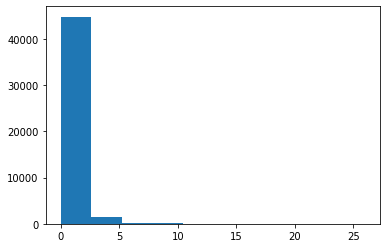

In [28]:
plt.hist(pingpong_df['pings'])